### 1. Load Libraries

In [884]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import data

%matplotlib inline

### 2. Load Dataset

In [885]:
# Extract and retrieve rentals data from Microsoft SQL server
# Refer to documentation within data module for technical and configuration details
df_rentals = data.get_rentals()

df_rentals.head()

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter
0,2012-07-02,23,clear,109.0,140.0,51.0,7.0,13,37,631
1,2011-12-22,10,cloudy,80.2,109.4,82.0,6.0,35,41,894
2,2011-02-25,11,clear,90.4,120.2,77.0,30.0,30,27,350
3,2012-03-10,1,clear,71.8,95.0,36.0,17.0,40,2,354
4,2011-06-19,5,cloudy,102.2,132.8,78.0,0.0,1,23,82


### 3. Data Insights <a id='data_insights'></a>

In [604]:
df_rentals.shape

(18643, 10)

- Dataset contains 18,643 observations with 10 features.


- There are 24 hours a day, 365 days a year. So over 2 years, there should be a maximum 17,520 (24 x 365 x 2) observations.


- Given that there are more hourly observations than hours over a 2 year period, some of the observations may be duplicates or erroneous. 


- The problem statement is to predict the total number of active e-scooter users given the above dataset.


- Each observation records the number of guest and registered users using rental e-scooters in a particular hour of a day.


- I shall assume that the total number of active e-scooter users in a particular hour of a day is the sum of the guest and registered users <i><b>i.e. active users = guest users + registered users.</b></i>

In [605]:
df_rentals.columns.values

array(['date', 'hr', 'weather', 'temperature', 'feels_like_temperature',
       'relative_humidity', 'windspeed', 'psi', 'guest_scooter',
       'registered_scooter'], dtype=object)

- Column labels of the rentals dataset

In [141]:
df_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18643 entries, 0 to 18642
Data columns (total 10 columns):
date                      18643 non-null object
hr                        18643 non-null int64
weather                   18643 non-null object
temperature               18643 non-null float64
feels_like_temperature    18643 non-null float64
relative_humidity         18643 non-null float64
windspeed                 18643 non-null float64
psi                       18643 non-null int64
guest_scooter             18643 non-null int64
registered_scooter        18643 non-null int64
dtypes: float64(4), int64(4), object(2)
memory usage: 1.4+ MB


- No column with null/missing value.

### 4. Summary Statistics <a id='summary_statistics'></a>

In [477]:
df_rentals.describe()

,hr,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter
count,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000
mean,11.537145,88.433037,117.313608,62.733251,12.741082,25.142198,106.388940,1074.471383
std,6.924281,16.252200,20.364081,19.315897,8.217008,14.442978,147.151664,1055.916934
min,0.000000,48.100000,60.800000,0.000000,0.000000,0.000000,-2.000000,-2.000000
25%,6.000000,75.200000,100.400000,48.000000,7.000000,13.000000,12.000000,240.000000
50%,12.000000,88.700000,118.400000,63.000000,13.000000,25.000000,50.000000,807.000000
75%,18.000000,102.200000,134.600000,78.000000,17.000000,38.000000,144.000000,1535.500000
max,23.000000,131.000000,179.600000,100.000000,57.000000,50.000000,1099.000000,6203.000000


- Large differnece in the 75th %tile and max values of columns <b>windspeed</b>, <b>guest_scooter</b>, <b>registered_scooter</b>


- This observation suggests that there are extreme values or outliers in these columns. 


- There is sizable difference in the range of values across the independent variables. e.g. values for <b>psi</b> are always below 100, whereas values for <b>registered_scooter</b> could be in the thousands.


- Some form of scaling needs to be done at the pre-processing stage.

### 5. Data Cleaning

#### 5.1 <b style="font-family:'Courier New'; font-size:18px">date</b> Column

In [142]:
# Check data type of the date column
df_rentals.dtypes['date']

dtype('O')

- Convert the <b style="font-family:'Courier New'; font-size:15px">date</b> column from <b style="font-family:'Courier New'; font-size:15px">string</b> to <b style="font-family:'Courier New'; font-size:15px">date</b> data type.


- Combine the <b style="font-family:'Courier New'; font-size:15px">date</b> and <b style="font-family:'Courier New'; font-size:15px">hr</b> columns to form a <b style="font-family:'Courier New'; font-size:15px">datetime</b> column.


- This is to facilitate the use of datetime/timeseries operations when doing exploration and feature engineering later.

In [886]:
# Rename date column to date_str to indicate string data type
df_rentals.rename(columns={'date': 'date_str'}, inplace=True)

# Convert date column from string to datetime data type
df_rentals['date'] = pd.to_datetime(df_rentals['date_str'])

# Verify date column data type
df_rentals.dtypes['date']

dtype('<M8[ns]')

In [887]:
# Create datetime column by concatenating the date and hr columns
df_rentals['datetime'] = df_rentals.apply(lambda row: row.date_str + ' ' + str(row.hr), axis=1) + ':00'

# Convert datetime column from string to datetime data type
df_rentals.datetime = pd.to_datetime(df_rentals.datetime)

# Verify datetime column data type
df_rentals.dtypes['datetime']

dtype('<M8[ns]')

#### 5.2 <b style="font-family:'Courier New'; font-size:18px">hr</b> Column <a id='hr_column'></a>

In [423]:
# Check data type of the hr column
df_rentals.dtypes['hr']

dtype('int64')

- The hour of the day when the rentals are made should be categorical in nature.


- Convert the <b>hr</b> column from integer to string data type.

In [888]:
# Rename hr column to hr_str to indicate string data type
df_rentals.rename(columns={'hr': 'hr_str'}, inplace=True)

# Convert hr column from int to string data type
df_rentals.hr_str = df_rentals.hr_str.apply(str)

# Verify hr_str column data type
df_rentals.dtypes['hr_str']

dtype('O')

In [465]:
# Check the number of unique hr values
unique_hrs = df_rentals.hr_str.unique()

unique_hrs

array(['23', '10', '11', '1', '5', '17', '22', '7', '18', '0', '9', '15',
       '12', '19', '4', '8', '2', '20', '6', '16', '21', '3', '14', '13'],
      dtype=object)

In [454]:
len(unique_hrs)

24

- All 24 hours of the day are represented in the rentals dataset.

In [889]:
# Convert the hr column from string to categorical data type
df_rentals['hr'] = df_rentals.hr_str.astype('category')

df_rentals.dtypes['hr']

CategoricalDtype(categories=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17',
                  '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6',
                  '7', '8', '9'],
                 ordered=False)

#### 5.3 <b style="font-family:'Courier New'; font-size:18px">weather</b> Column <a id='weather_column'></a>

In [610]:
df_rentals.weather.unique()

array(['clear', 'cloudy', 'light snow/rain', 'loudy', 'CLOUDY', 'CLEAR',
       'lear', 'LIGHT SNOW/RAIN', 'clar', 'heavy snow/rain', 'cludy',
       'liht snow/rain'], dtype=object)

- The <b>weather</b> column contains categorical data.
- The <b>weather</b> data is 'dirty', clean up is neccessary. 
- Mixed cases i.e. clear and CLEAR..
- Incorrect spelling e.g. lear, clar


- Correct values 'lear' and 'clar' to be 'clear'.
- Correct values 'cludy' and 'loudy' to be 'cloudy'.
- Correct value 'liht snow/rain' to be 'light snow/rain'.

In [890]:
# Standardized weather column to lower case characters
df_rentals.weather = df_rentals.weather.str.lower()

dict_weather = {

    # Replace incorrect values 'lear' and 'clar' with 'clear'
    'lear': 'clear',
    'clar': 'clear',

    # Replace incorrect values 'cludy' and 'loudy' with 'cloudy'
    'cludy': 'cloudy',
    'loudy': 'cloudy',

    # Replace incorrect value 'liht snow/rain' with 'light snow/rain'
    'liht snow/rain': 'light snow/rain'
}

# Replace incorrect values in weather column
df_rentals.replace({'weather': dict_weather}, inplace=True)

# Verify that the incorrect values have been replaced
df_rentals.weather.unique()

array(['clear', 'cloudy', 'light snow/rain', 'heavy snow/rain'],
      dtype=object)

In [891]:
# Convert the weather column from string to categorical data type
df_rentals['weather'] = df_rentals.weather.astype('category')

df_rentals.dtypes['weather']

CategoricalDtype(categories=['clear', 'cloudy', 'heavy snow/rain', 'light snow/rain'], ordered=False)

- The <b>weather</b> column contains 4 unique categorical values i.e. clear, cloudy, light snow/rain and heavy snow/rain.


- One-hot encoding can be applied to the <b>weather</b> column later in feature engineering.

#### 5.4 <b style="font-family:'Courier New'; font-size:18px">temperature</b>, <b style="font-family:'Courier New'; font-size:18px">feels_like_temperature</b> Columns<a id='temperature_feels_like_temperature_columns'></a>

In [17]:
# Get the maximum and minimum temperature recorded
max(df_rentals.temperature), min(df_rentals.temperature)

(131.0, 48.1)

In [18]:
# Get maximum and minimum feels_like_temperature recorded
max(df_rentals.feels_like_temperature), min(df_rentals.feels_like_temperature)

(179.6, 60.8)

In [19]:
# Number of observations with temperatures above 120°F
len(df_rentals[df_rentals.temperature > 120])

240

- I shall assume that values from the <b>temperature</b> and <b>feels_like_temperature</b> columns are in fahrenheit.

- I shal assume that this dataset is gathered from a city/town since people are renting e-scooters and e-bikes.


- The maximum value of the <b>temperature</b> column is 131°F which is pretty close to the [highest temperature ever recorded](https://en.wikipedia.org/wiki/List_of_weather_records#Highest_temperatures_ever_recorded) of 134.1°F.


- According to [TripSavvy](https://www.tripsavvy.com/the-worlds-hottest-cities-4070053), some of the highest temperatures recorded in a city include Phoenix 122°F, Marrakech 120°F, Mecca 121.6°F, Kuwait City 126°F, Ahvaz 129°F and Timbuktu 120°F.


- There are 240 observations with temperatures above 120°F.  This dataset should be from a city known for its high temperatures. If otherwise, the temperatures in these observations need to be verified.


- 'Feels like' temperature is also known as the [heat index](https://en.wikipedia.org/wiki/Heat_index).  In short, it is a temperature reading that factors in a component of relative humidity.


- We can verify the values of the <b>feels_like_temperature</b> column using the heat index [formula](https://en.wikipedia.org/wiki/Heat_index#Formula).


- Without any geographical information on this dataset given, I shall assume that all temperature readings are accurate. 

#### 5.5 <b style="font-family:'Courier New'; font-size:18px">relative_humidity</b> Column

In [20]:
# Get the maximum and minimum values of relative humidity recorded
max(df_rentals.relative_humidity), min(df_rentals.relative_humidity)

(100.0, 0.0)

In [437]:
# Number of observations with 0 relative humidity
len(df_rentals[df_rentals.relative_humidity==0])

25

- [Relative humidity](https://en.wikipedia.org/wiki/Relative_humidity) (RH) is the actual amount of water vapor present in relation to the capacity that the air has at a particular temperature.  It is express as a percentage.


- A relative humidity reading of 0 implies [air devoid of water vapor](https://www.chicagotribune.com/news/ct-xpm-2011-12-16-ct-wea-1216-asktom-20111216-story.html). This is quite impossible given the climate conditions of a city/town, where I assume this dataset is gathered.  Values of 0 in the <b>relative_humidity</b> column need to be verified.


- Since there are only 25 observations with 0 relative humidity, I've decided to drop them.


- A relative humidity reading of 100 means that the air is totally saturated with water vapor and cannot hold any more, creating the possibility of rain.  So values of 100 in the <b>relative_humidity</b> column are valid.

In [515]:
# Number of observations in dataset
len(df_rentals)

18643

In [892]:
# Drop observations with relative humidity value of 0
df_rentals.drop(df_rentals[df_rentals.relative_humidity==0].index, inplace=True)

# Check number of observations left after dropping
len(df_rentals)

18618

#### 5.6 <b style="font-family:'Courier New'; font-size:18px">windspeed</b> Column


In [29]:
# Get the maximum and minimum values of the windspeed column
max(df_rentals.windspeed), min(df_rentals.windspeed)

(57.0, 0.0)

- No units were given for the <b>windspeed</b> column.


- Apparently, wind speed can be measured using a variety of [units](https://en.wikipedia.org/wiki/Wind_speed#Units) e.g. beaufort, knots, m/s, km/h, mph, depending on purpose, region or target audience.


- [Wind speed of 0](https://www.wral.com/weather/blogpost/1116592/) is possible and said to be calm.


- I'm unable to gauge if the maximum wind speed of 57 is valid. 57 m/s implies a hurricane, but 57 km/h is just a near gale.  


- As such, I shall assume that values in the <b>windspeed</b> column are valid.


#### 5.7 <b style="font-family:'Courier New'; font-size:18px">psi</b> Column

In [33]:
# Get the maximum and minimum values of the psi column
max(df_rentals.psi), min(df_rentals.psi)

(50, 0)

- The [Pollutant Standard Index (psi)](https://en.wikipedia.org/wiki/Pollutant_Standards_Index) is a measure of pollutants present in the air (0 to 400). 


- Values in the <b>psi</b> column are valid.

#### 5.8 <b style="font-family:'Courier New'; font-size:18px">guest_scooter</b>, <b style="font-family:'Courier New'; font-size:18px">registered_scooter</b> Columns

In [486]:
# Get the maximum and minimum values of the guest_scooter column
max(df_rentals.guest_scooter), min(df_rentals.guest_scooter)

(1099, -2)

In [487]:
# Get the maximum and minimum values of the registered_scooter column
max(df_rentals.registered_scooter), min(df_rentals.registered_scooter)

(6203, -2)

In [893]:
# Number of observations with a negative value in either the guest_scooter or registered_scooter columns
len(df_rentals[(df_rentals.guest_scooter<0) | (df_rentals.registered_scooter<0)])

658

- Values in the <b>guest_scooter</b> and <b>registered_scooter</b> columns indicate the number of guest and registered users renting e-scooters in a particular hour, of a particular date.


- As such, the values in the <b>guest_scooter</b> and <b>registered_scooter</b> columns should not be negative.


- There are 658 observations with a negative value in either the <b>guest_scooter</b> or <b>registered_scooter</b> columns.


- As there is no way of verifying these erroneous values, I shall set all negative values in the <b>guest_scooter</b> or <b>registered_scooter</b> columns to 0.

In [894]:
# Set all negative values in the guest_scooter column to 0
df_rentals.loc[df_rentals.guest_scooter < 0, 'guest_scooter'] = 0

# Set all negative values in the registered_scooter column to 0
df_rentals.loc[df_rentals.registered_scooter < 0, 'registered_scooter'] = 0

# Verify that there all negative values in the guest_scooter and registered_scooter columns have been set to 0
len(df_rentals[(df_rentals.guest_scooter<0) | (df_rentals.registered_scooter<0)])

0

#### 5.9 Duplicate Observations

In [519]:
# Number of observations in dataset
len(df_rentals)

18618

- As mentioned in Section 3. [Data Insights](#data_insights), there are more hourly observations than hours over 2 years from 2011 to 2012.


- There are 18,618 hourly observations versus 17,520 (24 x 365 x 2) hours in the years 2011 and 2012.


- Therefore, there are duplicate or erroneous observations in the dataset.

In [633]:
# Number of observations that are duplicates
len(df_rentals[df_rentals.duplicated()])

1609

- There are 1,609 duplicate observations in the dataset.

 
- I shall drop these duplicated observations.

In [895]:
# Drop duplicate observations
df_rentals.drop_duplicates(inplace=True)

# Verify that the duplicate observations have been removed
len(df_rentals), any(df_rentals.duplicated())

(17009, False)

In [896]:
# Verify that all 17,009 observations have unique datetime values
len(df_rentals.datetime.unique())

17009

### 6. Target/Dependent Variable

- The target variable i.e. active e-scooter users, is numerical and discrete in nature.


- As mentioned in Section 3. [Data Insights](#data_insights), the target variable (active e-scooter users) will be the sum of the guest and registered e-scooter users.


- The <b>active_scooter</b> column should be created <b>AFTER</b> data cleaning as both the <b>guest_scooter</b> and <b>registered_scooter</b> columns contain errors.


- Creating the <b>active_scooter</b> column before data cleaning would have introduced those pre-existing errors into the target variable column.

In [897]:
# Create active_scooter column as target variable
df_rentals['active_scooter'] = df_rentals.guest_scooter + df_rentals.registered_scooter

# Verify target variable column has been created
df_rentals.columns

Index(['date_str', 'hr_str', 'weather', 'temperature',
       'feels_like_temperature', 'relative_humidity', 'windspeed', 'psi',
       'guest_scooter', 'registered_scooter', 'date', 'datetime', 'hr',
       'active_scooter'],
      dtype='object')

### 7. Feature Engineering

#### 7.1 Day of the Week <a id='day_of_the_week'></a>

- The day of the week will probably have an impact on the number of rentals.  There could be more rentals on work days (Mon-Fri) as people commute to work, and less on weekends (Sat-Sun) as people stay at home.


- I will create a new feature/variable based on the day of week.


- The day of the week is categorical in nature.

In [898]:
# Create day_of_wk column as independent variable
df_rentals['day_of_wk'] = df_rentals.apply(lambda row: row.datetime.strftime('%A'), axis=1)

# Verify day_of_wk variable column has been created
df_rentals.columns

Index(['date_str', 'hr_str', 'weather', 'temperature',
       'feels_like_temperature', 'relative_humidity', 'windspeed', 'psi',
       'guest_scooter', 'registered_scooter', 'date', 'datetime', 'hr',
       'active_scooter', 'day_of_wk'],
      dtype='object')

In [899]:
# Convert the day_of_wk column from string to categorical data type
df_rentals['day_of_wk'] = df_rentals.day_of_wk.astype('category')

df_rentals.dtypes['day_of_wk']

CategoricalDtype(categories=['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
                  'Tuesday', 'Wednesday'],
                 ordered=False)

#### 7.2 One-Hot Encoding

- There are several independent variables that are categorical in nature .i.e. the [<b>hr</b>](#hr_column) (Section 5.2), [<b>weather</b>](#weather_column) (Section 5.3)  and [<b>day_of_wk</b>](#day_of_the_week) (Section 6.2) columns.


- To facilitate further exploration and modelling later, I will one-hot encode these columns.


- I did not choose to label encode as assigning a running number series to categories has the disadvantage that the numerical values can be misinterpreted by machine learning algorithms as having some sort of hierarchy/order in them.


- After encoding, the original column encoded will be removed.  As such, I shall store the encoded dataset in a separate dataframe i.e. <b>df_rentals_1hot</b>, as I may need the original un-encoded dataset at a later stage.  Also, not all algorithms require categorical variables to be one-hot encoded.

In [900]:
# One-hot encode the hr column
df_rentals_1hot = pd.get_dummies(df_rentals, columns=['hr'], prefix=['hr'])

# Verify hr encoding columns were created
df_rentals_1hot.columns

Index(['date_str', 'hr_str', 'weather', 'temperature',
       'feels_like_temperature', 'relative_humidity', 'windspeed', 'psi',
       'guest_scooter', 'registered_scooter', 'date', 'datetime',
       'active_scooter', 'day_of_wk', 'hr_0', 'hr_1', 'hr_10', 'hr_11',
       'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19',
       'hr_2', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'hr_3', 'hr_4', 'hr_5',
       'hr_6', 'hr_7', 'hr_8', 'hr_9'],
      dtype='object')

In [901]:
# Create binary values for weather category values
df_rentals_1hot = pd.get_dummies(df_rentals_1hot, columns=['weather'], prefix=['weather'])

# Verify weather encoding columns were created
df_rentals_1hot.columns

Index(['date_str', 'hr_str', 'temperature', 'feels_like_temperature',
       'relative_humidity', 'windspeed', 'psi', 'guest_scooter',
       'registered_scooter', 'date', 'datetime', 'active_scooter', 'day_of_wk',
       'hr_0', 'hr_1', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15',
       'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_2', 'hr_20', 'hr_21', 'hr_22',
       'hr_23', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
       'weather_clear', 'weather_cloudy', 'weather_heavy snow/rain',
       'weather_light snow/rain'],
      dtype='object')

In [902]:
# One-hot encode the day_of_wk column
df_rentals_1hot = pd.get_dummies(df_rentals_1hot, columns=['day_of_wk'], prefix=['day_of_wk'])

# Verify day_of_wk encoding columns were created
df_rentals_1hot.columns

Index(['date_str', 'hr_str', 'temperature', 'feels_like_temperature',
       'relative_humidity', 'windspeed', 'psi', 'guest_scooter',
       'registered_scooter', 'date', 'datetime', 'active_scooter', 'hr_0',
       'hr_1', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16',
       'hr_17', 'hr_18', 'hr_19', 'hr_2', 'hr_20', 'hr_21', 'hr_22', 'hr_23',
       'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'weather_clear',
       'weather_cloudy', 'weather_heavy snow/rain', 'weather_light snow/rain',
       'day_of_wk_Friday', 'day_of_wk_Monday', 'day_of_wk_Saturday',
       'day_of_wk_Sunday', 'day_of_wk_Thursday', 'day_of_wk_Tuesday',
       'day_of_wk_Wednesday'],
      dtype='object')

### 7. Data Visualization

#### 7.1 Correlation <a id='correlation'></a>

In [919]:
# Column labels of all numerical independent variables
cols_numerical = ['guest_scooter', 'registered_scooter', 'temperature', 'feels_like_temperature', 
                  'relative_humidity', 'windspeed', 'psi']

# Column labels of weather one-hot encoded variables
cols_weather = ['weather_clear', 'weather_cloudy', 'weather_heavy snow/rain', 'weather_light snow/rain']

# Column labels of day of week one-hot encoded variables
cols_day_of_wk = ['day_of_wk_Friday', 'day_of_wk_Monday', 'day_of_wk_Saturday', 'day_of_wk_Sunday', 
                  'day_of_wk_Thursday', 'day_of_wk_Tuesday', 'day_of_wk_Wednesday']

# Column labels of hour one-hot encoded variables
cols_hr = ['hr_0', 'hr_1', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 
           'hr_2', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9']

cols_categorical = []

cols_categorical.extend(cols_weather)
cols_categorical.extend(cols_day_of_wk)
cols_categorical.extend(cols_hr)

# Construct list of column labels of numerical and one-hot encoded variables 
cols_all = ['active_scooter']

cols_all.extend(cols_numerical)
cols_all.extend(cols_categorical)

In [920]:
# Create new dataset for visualization purposes
df_rentals_viz = df_rentals_1hot.loc[:, cols_all]

# Generate the correlation matrix between features of the rental dataset
corr_rentals = df_rentals_viz.corr()

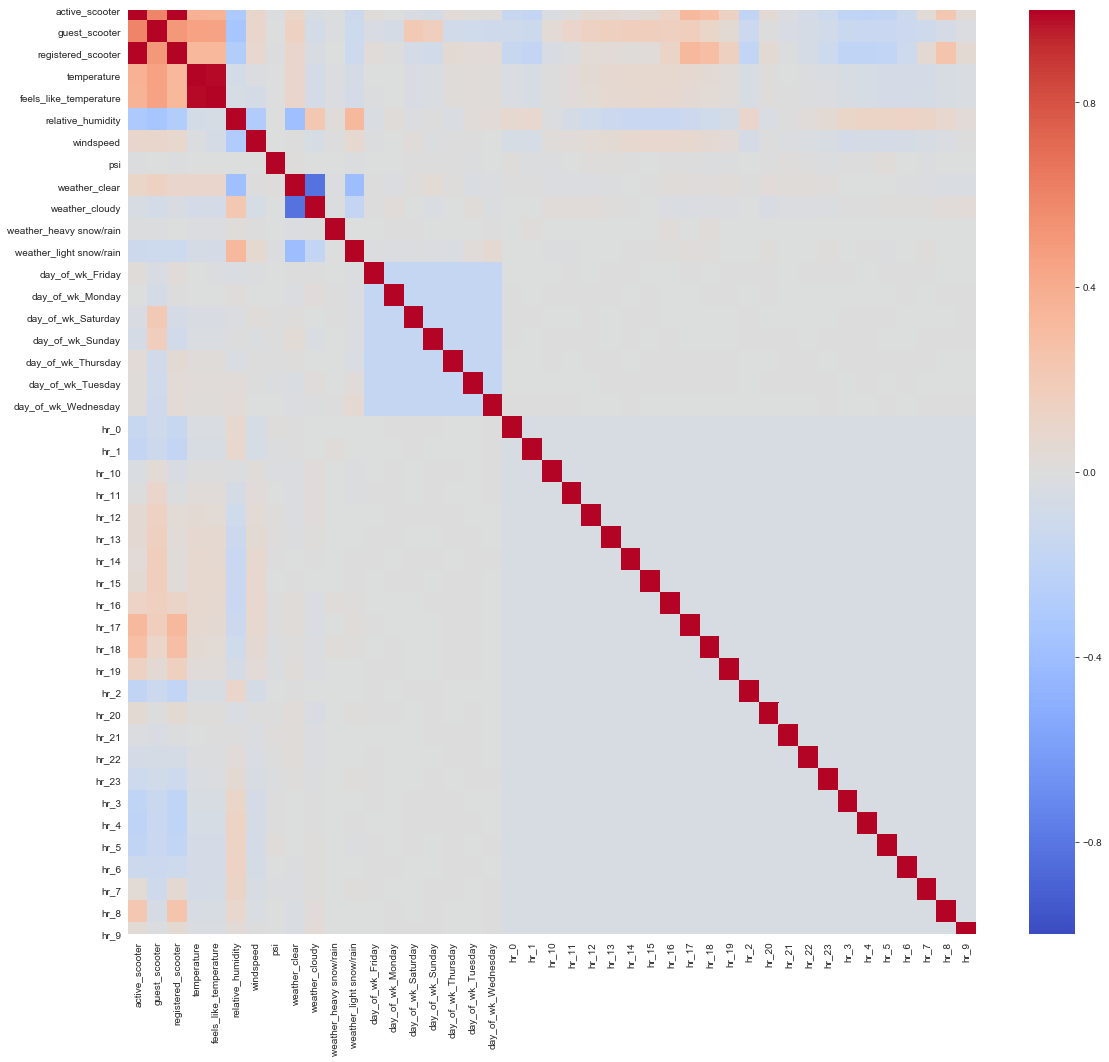

In [921]:
plt.figure(figsize=(19, 17))

# Display heat map of the correlation matrix
sns.heatmap(corr_rentals, cmap='coolwarm', annot=False, vmax=1, vmin=-1) 

In [971]:
# Get the correlation coefficients of the target variable (active_scooter) 
coefficients = corr_rentals['active_scooter'].sort_values(ascending=False)

# Get 10 most positively correlated indepedent variable
coefficients.iloc[:10]

active_scooter            1.000000
registered_scooter        0.993727
guest_scooter             0.599002
temperature               0.369943
feels_like_temperature    0.366657
hr_17                     0.323805
hr_18                     0.282614
hr_8                      0.228570
hr_19                     0.147046
hr_16                     0.129006
Name: active_scooter, dtype: float64

In [973]:
# Get 10 most negatively correlated indepedent variable
coefficients.iloc[-10:]

hr_23                     -0.115535
weather_light snow/rain   -0.119854
hr_6                      -0.121624
hr_0                      -0.154816
hr_1                      -0.178456
hr_2                      -0.188390
hr_5                      -0.191673
hr_3                      -0.199488
hr_4                      -0.204436
relative_humidity         -0.304816
Name: active_scooter, dtype: float64

- <b>registered_scooter</b> has strong positive correlation (> 0.99) to the target variable <b>active_scooter</b>.  


- This is expected as <b>active_scooter</b> is the sum of <b>registered_scooter</b> and <b>guest_scooter</b>. 


- <b>guest_scooter</b> also has a positive correlation but not as strongly as <b>registered_scooter</b>. 


- This is because <b>registered_scooter</b> is the bigger part of the summation, on average it contributes up to 90% of the value of <b>active_scooter</b>.


- Features most correlated to the target variable are <b>registered_scooter</b>, <b>guest_scooter</b>, <b>temperature</b>, <b>feels_like_temperature</b> and <b>relative_humidity.</b>


In [924]:
# Create a dataset to compare guest, registered and total active users 
df_users = df_rentals_viz.loc[:, ['active_scooter', 'guest_scooter', 'registered_scooter']]

# Create a column that shows the percentage of registered users in the total active users
df_users['registered_scooter_%'] = df_users['registered_scooter'] / df_users['active_scooter'] * 100

# Get the mean (in %) of registered_scooter's contribution towards the active_scooter value
df_users['registered_scooter_%'].mean()

91.05239011532313

- <b>temperature</b> and <b>feels_like_temperature</b> presents strong positive correlation (0.99).  This is probably because <b>feels_like_temperature</b>, also known as heat index (refer to Section 5.4 [temperature, feels_like_temperature Columns](#temperature_feels_like_temperature_columns), is derived from <b>temperature</b> and <b>relative_humidity</b>.


- <b>weather_clear</b> and <b>weather_light snow/rain</b> are the more significant weather conditions.


- <b>day_of_wk_Saturday</b> and <b>day_of_wk_Sunday</b> are the more significant days in the week.


- It is intersting to note that <b>day_of_wk_Saturday</b> and <b>day_of_wk_Sunday</b> are positively correlated to <b>guest_scooter</b> but negatively correlated to <b>registered_scooter</b>.


- We can infer that on weekends (Saturday, Sunday), the number of guest users will increase while the registered users will drop. 


- <b>hr_8</b>, <b>hr_16</b>, <b>hr_17</b>, <b>hr_18</b>, <b>hr_19</b> are the more positively correlated hourly intervals. These time slots relate to the commute to work in the morning (08:00am) and the commute after work in the evening (04:00pm - 07:00pm).


- <b>hr_23</b>, <b>hr_0</b>, <b>hr_1</b>, <b>hr_2</b>, <b>hr_3</b>, <b>hr_4</b>, <b>hr_5</b>, <b>hr_6</b> are the more negatively correlated hourly intervals. These time slots relate to people resting at home (11:00pm - 06:00am) and thus do not commute or need e-scooters.

#### 7.2 Outliers <a id='outliers'></a>

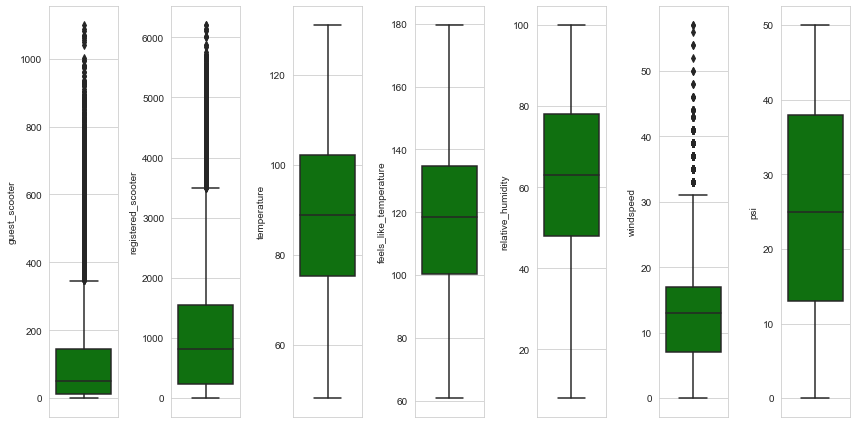

In [925]:
# Select columns with numerical data excluding the target variable
ol_cols = cols_numerical.copy()

df_outliers = df_rentals_viz[ol_cols]

cols_count = len(ol_cols)

plt.figure(figsize=(12, 6))

# Generate box plots for all numerical independent variables  
for i in range(0, cols_count):
    
    plt.subplot(1, cols_count, i+1)
    
    sns.set_style('whitegrid')
    
    sns.boxplot(df_outliers[ol_cols[i]], color='green', orient='v')
    
    plt.tight_layout()

- Independent variables <b>guest_scooter</b>, <b>registered_scooter</b> and <b>windspeed</b> contain large numbers of outliers.  These outliers may be removed later during pre-processing.


- Independent variables <b>temperature</b> and <b>feels_like_temperature</b> have similar distribution of values.

In [926]:
# Generate quantile and maximum values of numerical features

ser_quantile_1st = df_outliers.quantile(0.25)
ser_quantile_3rd = df_outliers.quantile(0.75)
ser_iqr = ser_quantile_3rd - ser_quantile_1st
ser_3iqr = ser_iqr * 1.5
ser_max = ser_quantile_3rd + ser_3iqr

df_boxplots = pd.DataFrame({'3rd': ser_quantile_3rd, '1st': ser_quantile_1st, 'iqr': ser_iqr, 
                            '3iqr': ser_3iqr, 'max': ser_max})
df_boxplots

,3rd,1st,iqr,3iqr,max
guest_scooter,145.0,11.0,134.0,201.0,346.0
registered_scooter,1541.0,241.0,1300.0,1950.0,3491.0
temperature,102.2,75.2,27.0,40.5,142.7
feels_like_temperature,134.6,100.4,34.2,51.3,185.9
relative_humidity,78.0,48.0,30.0,45.0,123.0
windspeed,17.0,7.0,10.0,15.0,32.0
psi,38.0,13.0,25.0,37.5,75.5


In [911]:
# Get number of outliers in the windspeed, guest_scooter, registered_scooter variables
len(df_outliers[df_outliers.windspeed>32]), len(df_outliers[df_outliers.guest_scooter>346]), len(df_outliers[df_outliers.registered_scooter>3491])

(329, 1147, 669)

#### 7.3 Distribution Skewness

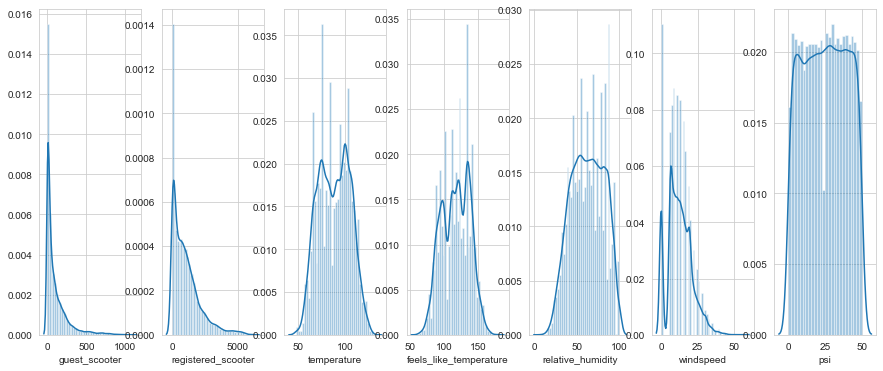

In [927]:
plt.figure(figsize=(15, 6))

# Generate distribution plots for all numerical independent variables  
for i in range(0, cols_count):
    
    plt.subplot(1, cols_count, i+1)
    
    sns.distplot(df_outliers[ol_cols[i]], kde=True) 

- Independent variables <b>guest_scooter</b>, <b>registered_scooter</b> and <b>windspeed</b> are right/positively skewed.


- Distribution plots of variables <b>temperature</b>, <b>feels_like_temperature</b> and <b>relative_humidity</b> are similar.

#### 7.4 Bar Charts <a id='bar_charts'></a>

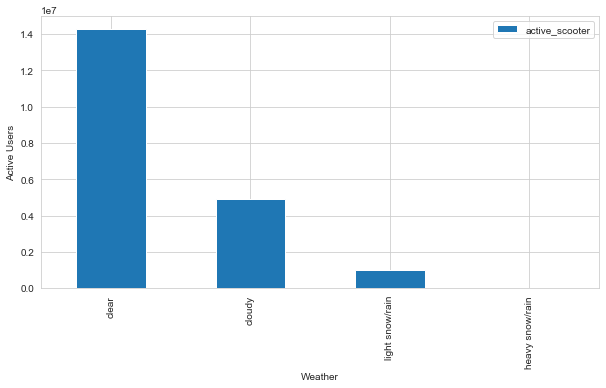

In [928]:
# Show distribution of users across weather conditions
df_users = df_rentals[['weather', 'active_scooter']]

df_users.groupby(['weather']).sum().sort_values(by='active_scooter', ascending=False).plot(kind='bar', figsize=(10,5))

plt.ylabel('Active Users')
plt.xlabel('Weather');

- There is an overwhelming number of users when weather was clear compared to other conditions.

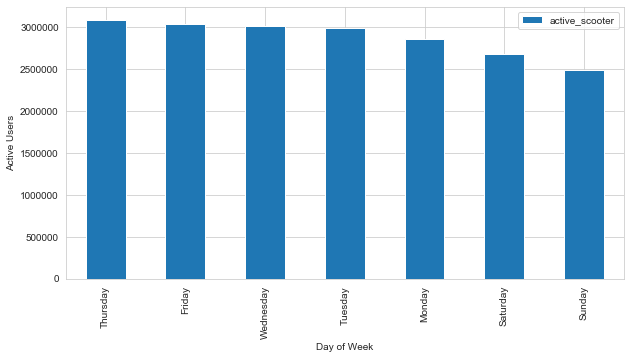

In [929]:
# Show distribution of users across days in a week
df_users = df_rentals[['day_of_wk', 'active_scooter']]

df_users.groupby(['day_of_wk']).sum().sort_values(by='active_scooter', ascending=False).plot(kind='bar', figsize=(10,5))

plt.ylabel('Active Users')
plt.xlabel('Day of Week');

- The number of users across work days (Mon-Fri) seem to be rather consistent. On weekends (Sat-Sun), there is a slight drop.

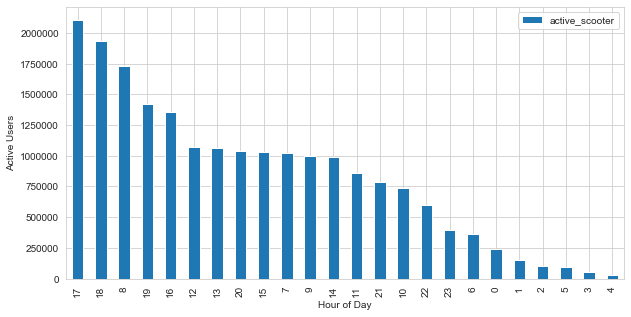

In [930]:
# Show distribution of users across days in a week
df_users = df_rentals[['hr', 'active_scooter']]

df_users.groupby(['hr']).sum().sort_values(by='active_scooter', ascending=False).plot(kind='bar', figsize=(10,5))

plt.ylabel('Active Users')
plt.xlabel('Hour of Day');

- There are most number of users during the morning (08:00am) and evening (16:00pm - 19:00pm) commute, probably to and from work.


- There are the least number of users after midnight into the early hours of the morning (01:00am - 05:00am), probably because people are resting at home.


- This is in line with findings from Section 7.1 [Correlation](#correlation).

### 8. Feature Pre-processing

#### 8.1 Remove Outliers

- From Section 7.2 [Outliers](#outliers), independent variables <b>guest_scooter</b>, <b>registered_scooter</b> and <b>windspeed</b> contain large numbers of outliers.


- I shall remove these outliers, taking reference from their box plots.

In [931]:
len(df_rentals), len(df_rentals_1hot)

(17009, 17009)

- Before removing outliers, we have 17,009 observations.

In [932]:
# Remove outliers from registered_scooter, guest_scooter and windspeed base on their maximum values in the box plots
df_rentals = df_rentals[df_rentals.registered_scooter<=3491]
df_rentals = df_rentals[df_rentals.guest_scooter<=346]
df_rentals = df_rentals[df_rentals.windspeed<=32]

len(df_rentals)

14933

- After removing outliers, I'm left with 14,933 observations.  That's about a 12% reduction of observations. 

In [933]:
# Remove outliers from dataset with one-hot encoding
df_rentals_1hot = df_rentals_1hot[df_rentals_1hot.registered_scooter<=3491]
df_rentals_1hot = df_rentals_1hot[df_rentals_1hot.guest_scooter<=346]
df_rentals_1hot = df_rentals_1hot[df_rentals_1hot.windspeed<=32]

len(df_rentals_1hot)

14933

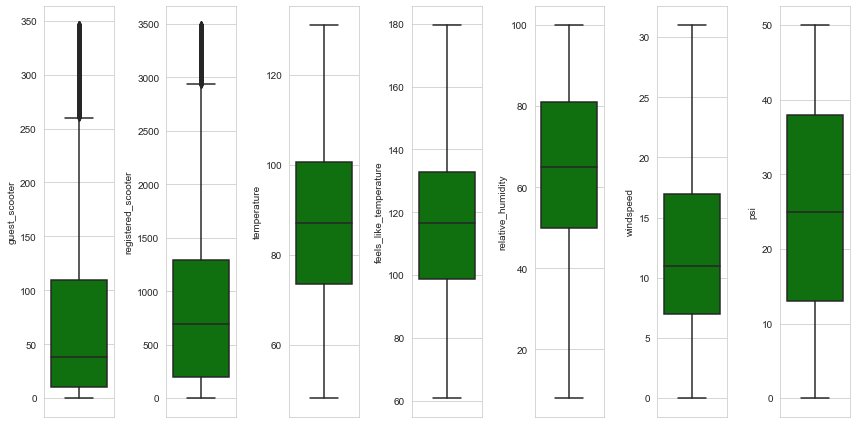

In [934]:
df_outliers = df_rentals[ol_cols]

cols_count = len(ol_cols)

plt.figure(figsize=(12, 6))

# Generate box plots for all numerical independent variables  
for i in range(0, cols_count):
    
    plt.subplot(1, cols_count, i+1)
    
    sns.set_style('whitegrid')
    
    sns.boxplot(df_outliers[ol_cols[i]], color='green', orient='v')
    
    plt.tight_layout()

- There still exist outliers in the variables <b>guest_scooter</b> and <b>registered_scooter</b>. However, their numbers have been siginificantly reduced as evident from the length of trailing dots.


- There are no more outliers in the <b>windspeed</b> variable.

#### 8.2 Scaling

- As mention in Section 4. [Summary Statistics](#summary_statistics), there is a need to perform scaling to the features due to the difference in the range of values. 


- Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed.


- To cater for algorithms that require close to 0 mean and unit variance, I've decided to use standard scaling.

In [935]:
cols_X = cols_all.copy()

cols_X.remove('active_scooter')

# Independent variables
X = df_rentals_1hot[cols_X] 

# Target/dependent variable
y = df_rentals_1hot['active_scooter']

In [936]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=19)

In [937]:
# Compare number of observations in train, test and original datasets
len(X_train), len(X_test), len(df_rentals_1hot)

(10005, 4928, 14933)

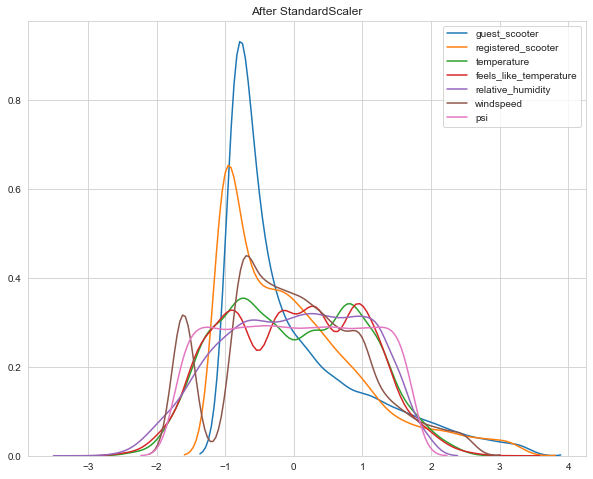

In [938]:
std_scaler = StandardScaler()

# Standard scale the independent variables of the train dataset
df_X_train_ss = std_scaler.fit_transform(X_train)
df_X_train_ss = pd.DataFrame(df_X_train_ss, columns=X_train.columns)

# Standard scale the independent variables of the test dataset
df_X_test_ss = std_scaler.fit_transform(X_test)
df_X_test_ss = pd.DataFrame(df_X_test_ss, columns=X_train.columns)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After StandardScaler')

sns.kdeplot(df_X_train_ss['guest_scooter'], ax=ax1)
sns.kdeplot(df_X_train_ss['registered_scooter'], ax=ax1)
sns.kdeplot(df_X_train_ss['temperature'], ax=ax1)
sns.kdeplot(df_X_train_ss['feels_like_temperature'], ax=ax1)
sns.kdeplot(df_X_train_ss['relative_humidity'], ax=ax1)
sns.kdeplot(df_X_train_ss['windspeed'], ax=ax1)
#sns.kdeplot(df_X_train_ss['weather_clear'], ax=ax1);
sns.kdeplot(df_X_train_ss['psi'], ax=ax1);
#sns.kdeplot(df_X_train_ss['hr_17'], ax=ax1);
#sns.kdeplot(df_X_train_ss['day_of_wk_Sunday'], ax=ax1);


### 8. Feature Selection

In [969]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

cols_select = cols_all.copy()

cols_select.remove('active_scooter')

X_select = df_rentals_1hot[cols_select]
y_select = df_rentals_1hot['active_scooter']

# Select the best 20 features based on univariate regression f-value 
bestfeatures = SelectKBest(score_func=f_regression, k=20)

fit_select = bestfeatures.fit(X_select, y_select)

df_scores = pd.DataFrame(fit_select.scores_)
df_columns = pd.DataFrame(X_select.columns)

scores = pd.concat([df_columns, df_scores], axis=1)

scores.columns = ['Column','Score']

# Print top 20 features with the highest scores
print(scores.nlargest(20, 'Score'))

                     Column         Score
1        registered_scooter  2.534632e+06
0             guest_scooter  1.097768e+04
2               temperature  1.841192e+03
3    feels_like_temperature  1.817975e+03
4         relative_humidity  1.319899e+03
36                     hr_4  8.411283e+02
35                     hr_3  7.899818e+02
28                    hr_18  7.711461e+02
29                    hr_19  7.113718e+02
37                     hr_5  7.042814e+02
30                     hr_2  6.738402e+02
27                    hr_17  6.561713e+02
19                     hr_1  5.764065e+02
26                    hr_16  5.256324e+02
18                     hr_0  3.859930e+02
40                     hr_8  3.639870e+02
31                    hr_20  2.578723e+02
41                     hr_9  2.294597e+02
14         day_of_wk_Sunday  2.193378e+02
10  weather_light snow/rain  1.949611e+02


- Comparing the top 20 features from SelectKBest (above) and the most correlated (positively/negatively) features from Section 7.1 [Correlation](#correlation), the following are the common features:

        - registered_scooter
        - guest_scooter
        - temperature
        - feels_like_temperature
        - relative_humidity
        - weather_light snow/rain
        - hr_0, hr_1, hr_2, hr_3, hr_4, hr_5, hr_8, hr_16, hr_17, hr_18, hr_19
        
        
- As mentioned in Section 7.1 [Correlation](#correlation), <b>temperature</b> and <b>feels_like_temperature</b> are highly correlated. <b>feels_like_temperature</b> is a heat index, calculated from <b>temperature</b> and <b>relative_humidity</b> (refer to Section 5.4 [temperature, feels_like_temperature Columns](#temperature_feels_like_temperature_columns)). As such, I will drop the feature <b>feels_like_temperature</b> as a predictor of <b>active_scooter</b>.


- From Section 7.4 [Bar Charts](#bar_charts), a large proportion of active users rented e-scooters when weather conditions were clear.  As such, I will include the feature <b>weather_clear</b>.


- The feature <b>day_of_wk_Sunday</b> is amongst one of the top 20 scores from SelectKBest.  Also from Section 7.4 [Bar Charts](#bar_charts), there seems to be less users on e-scooters on Sundays.  As such, I will include the feature <b>day_of_wk_Sunday</b>.


- Below is the list of 18 selected features:


        - registered_scooter
        - guest_scooter
        - temperature
        - relative_humidity
        - weather_clear
        - weather_light snow/rain
        - day_of_wk_Sunday
        - hr_0, hr_1, hr_2, hr_3, hr_4, hr_5, hr_8, hr_16, hr_17, hr_18, hr_19
        